In [1]:
from mrc import DVFile, imread
import numpy as np
from matplotlib import pyplot as plt
import imageio
import cv2
from PIL import Image, ImageStat
import os
from enum import Enum
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display, clear_output
import warnings
from ipywidgets import interact, interact_manual, widgets, Dropdown
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
from PIL import Image
%matplotlib inline


In [2]:
dv_files = []


class headerTuples(Enum):
    photosensorReading = 0
    timeStampSeconds = 1
    stageXCoord = 2
    stageYCoord = 3
    stageZCoord = 4
    minInten = 5
    maxInten = 6
    meanInten = 7
    expTime = 8
    ndFilter = 9
    exWavelen = 10
    emWavelen = 11
    intenScaling = 12
    energyConvFactor = 13


def read_as_nparray(filename: str):
    img_array = imread(filename)
    assert len(
        img_array) > 0, f"file {filename} is not a valid DV file or is corrupted."
    return img_array


def save_nparray_image_as_png(nparray_image: np.ndarray, directory: str, filename: str):
    assert len(
        nparray_image.shape) == 2, "pass one image at a time. e.g. a 500 by 500 array"
    imageio.imwrite(f"{filename}.png", nparray_image)


def find_dv_files(parent_dir='.'):
    global dv_files
    dv_files = []
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            _, ext = os.path.splitext(name)
            if ext == '.dv':
                # print(os.path.join(root, name))
                dv_files.append(os.path.join(root, name))


find_dv_files()


def load_dv_file(file_name):
    return DVFile(file_name)


def get_intensities(dv_img, type: str = 'mean'):
    intensities = []
    for i in range(81):
        if type == 'mean':
            intensities.append(dv_img.ext_hdr.frame(i)[
                headerTuples.meanInten.value])
        if type == 'min':
            intensities.append(dv_img.ext_hdr.frame(i)[
                headerTuples.minInten.value])
        if type == 'max':
            intensities.append(dv_img.ext_hdr.frame(i)[
                headerTuples.maxInten.value])
    return intensities


def get_dv_data(img: DVFile):
    return img.asarray()


In [3]:
# dv_file = load_dv_file(dv_files[0])
# meanIntensities = []
# meanIntensities = get_intensities(dv_file)
# image = get_dv_data(dv_file)
# all_slices = np.ndarray((82, 960, 960))
# all_slices = np.concatenate((image[0], image[1]))


In [4]:
# @interact
# def showImageByIndex(index= widgets.IntSlider(min=0,max=40,value=0,step=1)):
#     # img_scaled = cv2.normalize(all_slices[index], dst=None, alpha=0, beta=512, norm_type=cv2.NORM_MINMAX)
#     fig, ax = plt.subplots(2, 2, figsize=(14, 14))
    
#     display(plt.imshow(all_slices[index],cmap=plt.cm.gray_r, interpolation='nearest'))
    
    

In [5]:
# def draw():
#     fig, axs = plt.subplots(2, 2, figsize=(14, 14))

#     def browse_images(filename):
#         n = 40
#         dv_file = load_dv_file(filename)
#         image = get_dv_data(dv_file)
#         all_slices = np.ndarray((82, 960, 960))
#         all_slices = np.concatenate((image[0], image[1]))
#         meanIntensities = []
#         meanIntensities = get_intensities(dv_file)
#         axs[0, 0].plot(meanIntensities[:40])
#         axs[0, 1].plot(meanIntensities[41:])
#         axs[1, 0].imshow(all_slices[0])
#         axs[1, 1].imshow(all_slices[41])
#         def view_image(i):
#             axs[1, 0].imshow(all_slices[i])
#             axs[1, 1].imshow(all_slices[i+40])
#             # plt.imshow(all_slices[i], cmap=plt.cm.gray_r, interpolation='nearest')
#             plt.show()
#             # return plt.imshow(all_slices[i], cmap=plt.cm.gray_r, interpolation='nearest')

#         interact(view_image, i=(0, n))
#     interact(browse_images, filename=widgets.Dropdown(
#         options=dv_files, description="Select file to analyze"))
#     fig


# draw()


In [26]:
def draw():

    @interact
    def brows_files(filename=widgets.Dropdown(options=dv_files, description="select file"), i=widgets.IntSlider(min=0, max=40, step=1, value=0)):
        dv_file = load_dv_file(filename)
        image = get_dv_data(dv_file)
        n = image.shape[1] - 1 if image is not None else 40
        all_slices = np.ndarray((82, 960, 960))
        all_slices = np.concatenate((image[0], image[1]))
        avgIntensities = []
        minIntensities = []
        maxIntensities = []
        avgIntensities = get_intensities(dv_file, 'mean')
        minIntensities = get_intensities(dv_file, 'min')
        maxIntensities = get_intensities(dv_file, 'max')
        

        # def mean(i, j): return np.mean(image[i, j])

        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        calcMeanIntens = []
        for j in range(len(all_slices)):
            calcMeanIntens.append(np.mean(all_slices[j]))
        
        calcMinIntens =[]
        for j in range(len(all_slices)):
            calcMinIntens.append(np.min(all_slices[j]))
            
        calcMaxIntens =[]
        for j in range(len(all_slices)):
            calcMaxIntens.append(np.max(all_slices[j]))

        axs[0, 0].imshow(image[0, i], cmap=plt.cm.gray_r, interpolation='nearest')
        axs[1, 0].imshow(image[1, i], cmap=plt.cm.gray_r, interpolation='nearest')

        axs[0, 1].plot(minIntensities[:n])
        axs[0, 1].plot(calcMinIntens[:n])
        axs[0, 1].plot(i, minIntensities[i], 'go')
        axs[1, 1].plot(minIntensities[n+1:])
        axs[1, 1].plot(calcMinIntens[n+1:])
        axs[1, 1].plot(i, minIntensities[n+1+i], 'go')
        axs[0, 1].set_title("minimum pixel intensity")

        axs[0, 2].plot(avgIntensities[:n])
        axs[0, 2].plot(calcMeanIntens[:n])
        axs[0, 2].plot(i, avgIntensities[i], 'go')
        axs[1, 2].plot(avgIntensities[n+1:])
        axs[1, 2].plot(calcMeanIntens[n+1:])
        axs[1, 2].plot(i, avgIntensities[n+1+i], 'go')

        axs[0, 2].set_title("average pixel intensity")

        axs[0, 3].plot(maxIntensities[:n])
        axs[0, 3].plot(calcMaxIntens[:n])
        axs[0, 3].plot(i, maxIntensities[i], 'go')
        axs[1, 3].plot(maxIntensities[n+1:])
        axs[1, 3].plot(calcMaxIntens[n+1:])
        axs[1, 3].plot(i, maxIntensities[n+1+i], 'go')
        axs[0, 3].set_title("maximum pixel intensity")

        fig.tight_layout()


draw()


interactive(children=(Dropdown(description='select file', options=('.\\Cpd1M9P-1\\220315Cpd1GlcM9P-02_R3D_01_D…

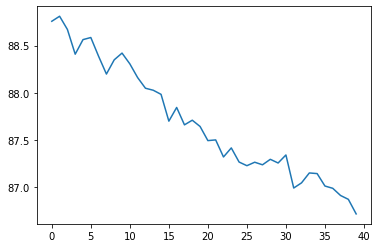

In [27]:
dv_file = load_dv_file(dv_files[0])
image = get_dv_data(dv_file)
all_slices = np.ndarray((82, 960, 960))
all_slices = np.concatenate((image[0], image[1]))

mycalc1 = []
mycalc2 = []
mycalc3 = []
for jj in range(81):
    im1 = Image.fromarray(all_slices[jj], mode='L')
    im2 = Image.fromarray(all_slices[jj], mode='P')
    im3 = Image.fromarray(all_slices[jj], mode='I;16')
    stat1 = ImageStat.Stat(im1)
    stat2 = ImageStat.Stat(im2)
    stat3 = ImageStat.Stat(im3)
    mycalc1.append(stat1.mean)
    mycalc2.append(stat2.mean)
    mycalc3.append(stat3.mean)

plt.plot(mycalc1[:40])
# plt.plot(mycalc[41:])


None


In [ ]:
def load_file_disp_plots(filename):
    # filename = sample.new
    dv_file = load_dv_file(filename)
    image = get_dv_data(dv_file)
    meanIntensities = []
    meanIntensities = get_intensities(dv_file)

    fig = make_subplots(rows=1, cols=2, subplot_titles=("01:41", "42:82"))
    fig.add_trace(
        go.Scatter(y=meanIntensities[:40]),
        1, 1)
    fig.add_trace(
        go.Scatter(y=meanIntensities[41:]),
        1, 2)

    fig.update_layout(title_text=file_name)
    slider1 = px.imshow(image[0, :, :, :], animation_frame=0,
                        binary_string=True, labels=dict(animation_frame="slice"))
    slider2 = px.imshow(image[1, :, :, :], animation_frame=0,
                        binary_string=True, labels=dict(animation_frame="slice"))
    display(fig)
    # display(slider1, slider2)


# choose_file = widgets.Dropdown(
#     options=dv_files, description="Select file to analyze")
imageSlider = widgets.IntSlider(min=0, max=82, step=1, value=0)


@interact
def showImage(slideNumber=imageSlider):
    display(plt.imshow(first_half[slideNumber]))


# imageSlider.observe(showImage, 'value')
# choose_file.observe(load_file_disp_plots, 'value')
# _ = interact(load_file_disp_plots, filename=dv_files)
# __ = interact(showImage, slideNumber=len(first_half))


In [ ]:

fig = make_subplots(rows=1, cols=2, subplot_titles=("01:41", "42:82"))

fig.add_trace(
    go.Scatter(y=meanIntensities[:40]),
    1, 1)
fig.add_trace(
    go.Scatter(y=meanIntensities[41:]),
    1, 2)

fig.update_layout(title_text=file_name)

display(fig.show())


In [ ]:
slider1 = px.imshow(img.data[1, :, 0, :, :], animation_frame=0,
                    binary_string=True, labels=dict(animation_frame="slice"))
# type(slider1)

ff = go.Figure(slider1)
fig.show()
ff.show()
# fig2 = make_subplots(rows=1, cols=2, subplot_titles=("01:41", "42:82"))
# # print(fig2)
# fig2.add_trace(img.data[1, :, 0, :, :],1,1)


In [ ]:
app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=ff)
])


# Turn off reloader if inside Jupyter
app.run_server(debug=True, use_reloader=False)


In [ ]:

# fig = px.imshow(img.data[1,:,0,:,:], animation_frame=0, binary_string=True,
#                 labels=dict(animation_frame="slice"))
fig1 = px.line(meanIntensities[0:40])
# fig.add_image(px.imshow(img.data[1,:,0,:,:], binary_string=True ),row=1,col=2)
fig1.show()
fig2 = px.imshow(img.data[1, :, 0, :, :], animation_frame=0,
                 binary_string=True, labels=dict(animation_frame="slice"))
fig2.show()


In [ ]:
imgdv = DVFile('./GlcM9P-3/220512GlcM9P-04_R3D_01_D3D.dv')
# imgdv.hdr
# imgdv.ext_hdr.frame(0)
imgdv.ext_hdr.frame(41)[headerTuples.meanInten.value]
meanIntensities = []
for i in range(81):
    meanIntensities.append(imgdv.ext_hdr.frame(i)[headerTuples.meanInten.value]
                           )
plt.plot(meanIntensities[0:40])
plt.show()
plt.plot(meanIntensities[41:])
plt.show()


In [ ]:
outputDir = os.path.join(os.path.expanduser("~"), "Desktop")
imageio.imwrite(f"{outputDir}\mypngfile1.png", img[0, 0], format="png")
# imageio.imwrite("mypngfile2.png",img[1,0],format="png")
# imageio.imwrite("mypngfile3.png",(img[1,0] + img[0,0])/2)
